# Notebook for Trial neural population decoding (NPD)
With inspiration from:
"The geometry of hippocampal CA2 representations enables abstract coding of social familiarity and identity" - Boyle 2022

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('../bioAI.mplstyle')
import expipe
import sys
import pathlib
import numpy as np
import numpy.ma as ma
import scipy
import tqdm
import pandas as pd

from scipy.interpolate import interp1d

sys.path.append('../ca2-mec') if '../ca2-mec' not in sys.path else None 
import dataloader as dl
from utils import *

In [3]:
project = expipe.get_project(dl.project_path())
project.actions

In [4]:
lim = [0,1200] # limit recording times - in seconds
#include_actions = ['011-120321-2', '011-120321-3', '011-120321-4', '011-120321-5', '011-120321-6'] # choose actions to include
include_actions = ['022-160322-1', '022-160322-2', '022-160322-3', '022-160322-4', '022-160322-5', '022-160322-7']

# Cast assertion error if include_actions contain actions from multiple entities. 
animal_entity = include_actions[0].split('-')[0]
multiple_entities = all([animal_entity in action_id for action_id in include_actions])
assert multiple_entities, "Requires only actions from same animal entity! Read start of notebook!"

spikes = []
tracking = {}
for action_id in include_actions:
    spikes += dl.load_spiketrains(action_id, lim=lim, identify_neurons=True)
    tracking[action_id] = dl.load_tracking(action_id, lim=lim, ca2_transform_data=True) # only get positions
    
print("load #spikes: ", len(spikes))
    
# correct for inconsistent mua-annotations
spikes = dl.correct_mua(spikes, only_good_mua=True)
print("#units after mua-corrections:", len(spikes))
spatial_map = sp.SpatialMap()

# SELECT brain region(s) to include cells from
spikes = dl.in_brain_regions(spikes, ['ca2'])
print("#units after brain region selection:", len(spikes))

# only include cells that are persistent across all actions
spikes = dl.persistent_units(spikes, include_actions)
print(f"Num spike_trains: {len(spikes)}. Num persistent units: {len(spikes) / len(include_actions)}")

load #spikes:  181
#units after mua-corrections: 172
#units after brain region selection: 166
Num spike_trains: 96. Num persistent units: 16.0


In [5]:
# sort spikes on id and action, respectively.
spikes.sort(key=lambda spike_train: spike_train.annotations['unit_idnum'])
spikes.sort(key=lambda spike_train: spike_train.annotations['action_id'])
include_actions.sort() # used to assign labels to y_true

# print the spike properties that the spikes list has been sorted on to confirm sorting
[(spike_train.annotations["action_id"], spike_train.annotations["unit_idnum"]) for spike_train in spikes]

[('022-160322-1', 3),
 ('022-160322-1', 5),
 ('022-160322-1', 6),
 ('022-160322-1', 10),
 ('022-160322-1', 11),
 ('022-160322-1', 13),
 ('022-160322-1', 15),
 ('022-160322-1', 16),
 ('022-160322-1', 18),
 ('022-160322-1', 20),
 ('022-160322-1', 34),
 ('022-160322-1', 35),
 ('022-160322-1', 38),
 ('022-160322-1', 39),
 ('022-160322-1', 40),
 ('022-160322-1', 43),
 ('022-160322-2', 3),
 ('022-160322-2', 5),
 ('022-160322-2', 6),
 ('022-160322-2', 10),
 ('022-160322-2', 11),
 ('022-160322-2', 13),
 ('022-160322-2', 15),
 ('022-160322-2', 16),
 ('022-160322-2', 18),
 ('022-160322-2', 20),
 ('022-160322-2', 34),
 ('022-160322-2', 35),
 ('022-160322-2', 38),
 ('022-160322-2', 39),
 ('022-160322-2', 40),
 ('022-160322-2', 43),
 ('022-160322-3', 3),
 ('022-160322-3', 5),
 ('022-160322-3', 6),
 ('022-160322-3', 10),
 ('022-160322-3', 11),
 ('022-160322-3', 13),
 ('022-160322-3', 15),
 ('022-160322-3', 16),
 ('022-160322-3', 18),
 ('022-160322-3', 20),
 ('022-160322-3', 34),
 ('022-160322-3', 35

### Setup input data and labels
This should follow the format:
- X.shape = (samples, num_features) -> neural rate activity
- y.shape = (samples) -> scalars indicating labelled class

In [6]:
# CATEGORIES
# 0,1,2,3,4,(5) FIVE (or SIX) in total
# MEANING:
# 0: action1 (according to SORT of 'include_actions')
# 1: action2 (according to SORT of 'include_actions')
# 2: action3 (according to SORT of 'include_actions')
# 3: action4 (according to SORT of 'include_actions')
# 4: action5 (according to SORT of 'include_actions')
# 5: action6 (according to SORT of 'include_actions')

categories_to_include = [1, 2] # <--- SELECT categories to include

In [7]:
window_size = 0.1 # 0.1 is used in Boyle2022, i.e. 100ms
input_dim = int(len(spikes)/len(include_actions)) # number of persistent units
X = []
y_true = []

for k, action_id in enumerate(tracking):
    if k not in categories_to_include:
        continue
    
    _,_,t,_ = tracking[action_id].T
    trial_duration = t[-1] - t[0]
    num_samples = int(trial_duration / window_size) - 1
    X_tmp = np.zeros((input_dim, num_samples))
    y_tmp = np.zeros((num_samples))
    
    # set trial label - all labels for an action has the same label
    y_tmp += include_actions.index(action_id)
    
    for i in tqdm.trange(num_samples):
        time_window = (i*window_size, (i+1)*window_size)
        # loop units for current action_id
        action_spikes = [spike_train for spike_train in spikes if spike_train.annotations["action_id"] == action_id]
        for j, spike_train in enumerate(action_spikes):
            X_tmp[j,i] = np.sum((time_window[0] <= spike_train) & (spike_train <= time_window[1]))
        
    X.append(X_tmp)
    y_true.append(y_tmp)

X = np.concatenate(X,axis=1).T
y_true = np.concatenate(y_true)
print(X.shape, y_true.shape)

100%|██████████| 9251/9251 [00:01<00:00, 5741.90it/s]

(18374, 16) (18374,)


In [8]:
np.unique(X, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 array([262293,  18606,   6816,   3525,   1721,    713,    231,     54,
            15,      5,      3,      1,      1]))

## MACHINE LEARNING

In [9]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2, random_state=0)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [10]:
categories, counts = np.unique(y_true, return_counts=True)
print(f"Categories: {categories}.", "Probability of category:", counts/np.sum(counts))

print("\n SVM score: ", clf.score(X_test,y_test))

Categories: [1. 2.]. Probability of category: [0.49651682 0.50348318]

 SVM score:  0.6179591836734694


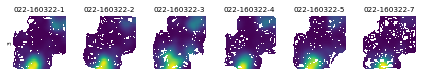

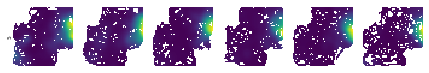

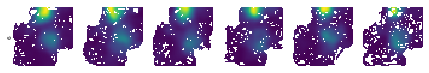

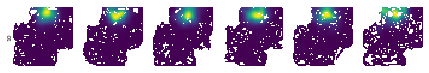

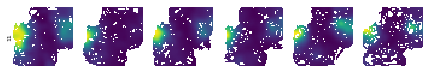

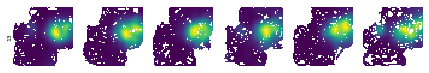

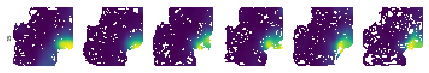

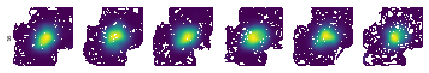

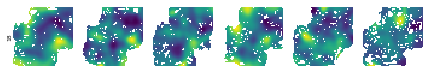

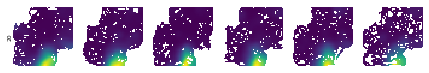

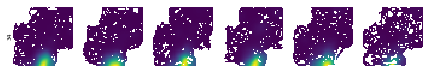

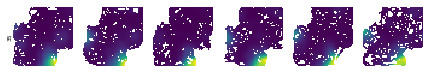

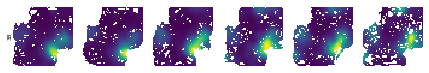

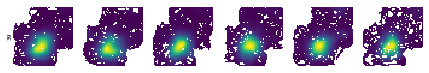

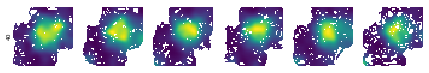

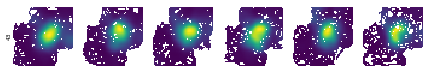

In [11]:
# sort on unit id
spikes.sort(key=lambda spike_train: spike_train.annotations['unit_idnum'])
unique_unit_idnums = np.unique([spike_train.annotations["unit_idnum"] for spike_train in spikes])
include_actions.sort()
figscale = 1
from plotting_functions import axis_off_labels_on

add_title = True
spatial_map = sp.SpatialMap()
for unit_idnum in unique_unit_idnums:
    unit_spikes = [spike_train for spike_train in spikes if spike_train.annotations["unit_idnum"] == unit_idnum]
    fig,axs = plt.subplots(ncols=len(unit_spikes),figsize=(len(unit_spikes)*figscale, 1*figscale))
    
    for ax, spike_train in zip(axs, unit_spikes):
        x,y,t,_ = tracking[spike_train.annotations["action_id"]].T
        ratemap = spatial_map.rate_map(x, y, t, spike_train)
        ax.imshow(ratemap.T,origin='lower')
        axis_off_labels_on(ax)
        
        # add action_id title to first few plots
        if add_title:
            ax.set_title(spike_train.annotations["action_id"])
    add_title = False
    
    axs[0].set_ylabel(spike_train.annotations["unit_idnum"])